
#### ____

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;                        Airbnb Analisys - Data Science
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Guilherme Tamer Lotaif

<br>



## 1. Introdução

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;   In this study, we will delve into an investigation of Airbnb data in the United States, focusing on relevant aspects. Based on this data, we will employ various **prediction techniques** to estimate rental prices, considering the specific features provided. The variety of methods used will allow for a comparative analysis of the results obtained.

**Airbnb:** It is a global platform for renting houses and apartments, offering a wide range of options in 192 countries. In the United States alone, there are approximately 600,000 potential rental places, highlighting the extent and diversity of the platform. Given so many options, users' decisions about where to stay are influenced by the information provided by the hosts, ranging from details like the number of bathrooms to the availability of Wi-Fi. 

**1<sup>o</sup> part**: Seeks to uncover patterns and insights through the analysis of this data, enabling a deeper understanding of the Airbnb rental market in the United States.

**2<sup>o</sup> part**: It aims to compare the effectiveness of different regression models based on datasets of various sizes to predict Airbnb rental prices, thus arriving at the most suitable model for the problem.

**Dataset:** www.kaggle.com/rudymizrahi/airbnb-listings-in-major-us-cities-deloitte-ml

___
## 2. Data mining

The dataset we will use in this project has various columns with information about Airbnb in the United States, with qualitative and quantitative variables. Therefore, we need to go through all these columns to clean the data, leaving only the information that will be relevant to our analysis.

In [1]:
#Importing libraries:
import os
import sys
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from statsmodels.formula.api import ols

plt.style.use('ggplot')

In [2]:
#Let's remove warnings to keep the display cleaner:
warnings.filterwarnings("ignore")

___

### 2.1 Database

So that we can work with the data obtained from the website www.kaggle.com, we first need to open the file. In this case, we will only open the training file (which will be split into training and testing in the future), as it already has a sufficient amount of data for us to do our work.

In [3]:
#Importing training file:
df = pd.read_csv('Data/train.csv')

In [4]:
#Analyzing the size of the training dataframe:
lines, columns = df.shape
print("The dataframe has {0} rows by {1} columns".format(lines, columns))

The dataframe has 74111 rows by 29 columns


In [5]:
linhas, colunas = df.shape

...

#### Cleaning the dataframe for analysis
This step consists of preparing the dataframe to facilitate its analysis, thus avoiding occurrences of complications or errors that may hinder the performance of our classifiers in the future. Therefore, we will: clean the spaces from the titles of each column; remove null values from each category, as well as delete columns that we consider unnecessary for our work.

In [6]:
#Removing white spaces from column titles:
df.columns = [spaces.strip() for spaces in df.columns.tolist()]

In [7]:
#Converting a percentage string to float:
df['host_response_rate'] = df['host_response_rate'].str.rstrip('%').astype('float')

In [8]:
#Removing columns that are not relevant to the study:
df = df.drop(["latitude","longitude","name","thumbnail_url","id","description","amenities","zipcode",
              "host_since","first_review","last_review"],axis=1);

In [9]:
#Deleting null values that can cause issues later:
df = df.dropna(axis=0, subset=['log_price', 'property_type', 'room_type', 'accommodates', 'bathrooms','bed_type',
                               'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'beds', 
                               'host_identity_verified','host_response_rate', 'instant_bookable', 'neighbourhood',
                               'review_scores_rating','bedrooms'])

In [10]:
#Correcting simplification in the file:
df.loc[(df["instant_bookable"] == "f"),"instant_bookable"] = "False"
df.loc[(df["instant_bookable"] == "t"),"instant_bookable"] = "True"

df.loc[(df["host_has_profile_pic"] == "f"),"host_has_profile_pic"] = "False"
df.loc[(df["host_has_profile_pic"] == "t"),"host_has_profile_pic"] = "True"

df.loc[(df["host_identity_verified"] == "f"),"host_identity_verified"] = "False"
df.loc[(df["host_identity_verified"] == "t"),"host_identity_verified"] = "True"

In [11]:
df.sample(2)

,log_price,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,host_response_rate,instant_bookable,neighbourhood,number_of_reviews,review_scores_rating,bedrooms,beds
38793,5.105945,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,NYC,True,True,50.0,False,Upper West Side,21,96.0,1.0,1.0
2382,4.691348,Apartment,Entire home/apt,4,1.0,Real Bed,strict,True,NYC,True,True,100.0,False,Lower East Side,15,89.0,2.0,2.0


In [12]:
#Analyzing the size of the training dataframe:
clean_lines, clean_columns = df.shape
print("After cleaning the dataframe has {0:.1f}% fewer rows and {1:.1f}% fewer columns".format(((lines-clean_lines)/lines)*100, ((columns-clean_columns)/columns)*100))

After cleaning the dataframe has 41.9% fewer rows and 37.9% fewer columns


...


#### Transforming qualitative categories into quantitative ones:
As our predictive models require quantitative variables, it is necessary to perform a conversion to enable the functioning of the tools.<br>

The method used to perform this conversion is called **One Hot Encoding**, which transforms categorical variables into binary vectors. This method transforms all variables into 0 unless the item (column) analyzed has a positive response, thus allowing us to perform analyses on this data.
<br>
<br>

In [13]:
#Função para chamar o get_dummies e remover a coluna base:
def dummify(data, column_name):
    df1 = data.copy()
    df2 = pd.concat([df1.drop(column_name, axis=1), pd.get_dummies(data[column_name], prefix=column_name)], axis=1)
    return df2

#Fazendo as conversões das nossas colunas:
df_models = dummify( df, "property_type")
df_models = dummify( df_models, "room_type")
df_models = dummify( df_models, "bed_type")
df_models = dummify( df_models, "cancellation_policy")
df_models = dummify( df_models, "cleaning_fee")
df_models = dummify( df_models, "city")
df_models = dummify( df_models, "host_has_profile_pic")
df_models = dummify( df_models, "host_identity_verified")
df_models = dummify( df_models, "instant_bookable")
df_models = dummify( df_models, "neighbourhood")

Now, we have a `df` that we will use for descriptive analysis, which is composed of both qualitative and quantitative variables. We also have the`df_models` that will be used for our regression models.

...
<br>

### 2.2 Exploratory Analysis:

With the intention of deepening the understanding of the factors that impact rental prices, this study aims to investigate the correlation between various variables and rental values. The analysis will encompass a set of specific attributes, providing insights into the influence of these variables on property rental prices.


#### Let's analyze the types of rooms:

First, let's discover the most common types of rooms, and then the average log value of the rental for each type.

In [14]:
#Let's find out the quantity of each room type in the data:
Tp_room = df.room_type.value_counts()

In [15]:
#Creating empty lists for each room type:
entire, private, shared = [],[],[]

#Let's use a loop to iterate through our dataframe:
for tp, price in zip(df['room_type'],df['log_price']):
    if tp == "Entire home/apt":
        entire.append(price)
    elif tp == "Private room":
        private.append(price)
    elif tp == "Shared room":
        shared.append(price)

In [16]:
colors = sns.color_palette('gist_heat')

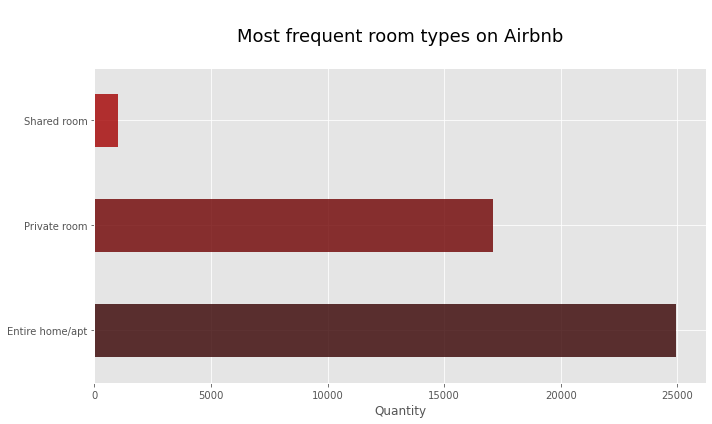

<Figure size 432x288 with 0 Axes>

In [17]:
# Criando um gráfico com os dados:
plot = Tp_room.plot(kind='barh', figsize=(10, 6), color=colors, alpha =0.8, align='center')
plt.title("\nMost frequent room types on Airbnb\n", fontsize=18)
plt.xlabel('Quantity')
plt.tight_layout()
plt.show()

#Creating the information table next to the chart:
plt.figtext(1.01, 0.8, "Average Prices (log):", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "Shared room: {:.2f}".format(np.mean(shared)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "Private room: {:.2f}".format(np.mean(private)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "Entire room: {:.2f}".format(np.mean(entire)), fontsize=14, va='center', ha='left')
plt.show()

The available quantity of each room type is related to the average price, so that the higher the average price, the greater the quantity of Airbnb.

...<br>


#### Let's analyze the property types:

Similar to the previous item, it will studied the most frequent types and their average rental values.

In [18]:
#Creating empty lists for each property type:
apartment, house, condominium, townhouse, loft = [],[],[],[],[]
#Creating null variables for each property type:
apartment_count, house_count, condominium_count, townhouse_count, loft_count = 0,0,0,0,0

#Let's use a loop to iterate through our dataframe:
for tp, price in zip(df['property_type'],df['log_price']):
    if tp == "Apartment":
        apartment.append(price)
        apartment_count += 1
    elif tp == "House":
        house.append(price)
        house_count += 1
    elif tp == "Condominium":
        condominium.append(price)
        condominium_count += 1
    elif tp == "Townhouse":
        townhouse.append(price)
        townhouse_count += 1
    elif tp == "Loft":
        loft.append(price)
        loft_count += 1
        
#Creating a variable to assign the total value among the 5 most common types:
Total_propriety = apartment_count + house_count + condominium_count + townhouse_count + loft_count

In [19]:
#Let's print the average prices:
markdown_text = "### Average prices for each type (log):"
display(Markdown(markdown_text))
print(" Apartment:  {:.2f}\n".format(np.mean(apartment)),
      "House:      {:.2f}\n".format(np.mean(house)),
      "Condominium:{:.2f}\n".format(np.mean(condominium)),
      "Townhouse:  {:.2f}\n".format(np.mean(townhouse)),
      "Loft:       {:.2f}".format(np.mean(loft)))

#Let's print the percentage of each type:
markdown_text = "### Percentage of the 5 most common types:"
display(Markdown(markdown_text))
print(" Apartment:  {0:.1f}%\n".format((apartment_count/Total_propriety)*100),
      "House:      {0:.1f}%\n".format((house_count/Total_propriety)*100),
      "Condominium:{0:.1f}%\n".format((condominium_count/Total_propriety)*100),
      "Townhouse:  {0:.1f}%\n".format((townhouse_count/Total_propriety)*100),
      "Loft:       {0:.1f}%".format((loft_count/Total_propriety)*100))

### Average prices for each type (log):

 Apartment:  4.76
 House:      4.77
 Condominium:4.96
 Townhouse:  4.81
 Loft:       5.00


### Percentage of the 5 most common types:

 Apartment:  67.6%
 House:      24.1%
 Condominium:3.8%
 Townhouse:  2.6%
 Loft:       1.9%


Thus, it is possible to identify the 5 most common property types, and also that the higher the quantity of Airbnbs for each property type, the lower the average price.

...

#### Let's analyze if the cities with more Airbnb have a price disparity

The following code already assumes the execution of a `value_counts()` method to identify the five cities with the highest supply.

In [20]:
#Creating empty lists for each city:
city_nyc, city_la, city_sf, city_dc, city_chicago = [],[],[],[],[]

#Let's use a loop to iterate through our dataframe:
for city, price in zip(df['city'],df['log_price']):
    if city == "NYC":
        city_nyc.append(price)
    elif city == "LA":
        city_la.append(price)
    elif city == "SF":
        city_sf.append(price)
    elif city == "DC":
        city_dc.append(price)
    elif city == "Chicago":
        city_chicago.append(price)

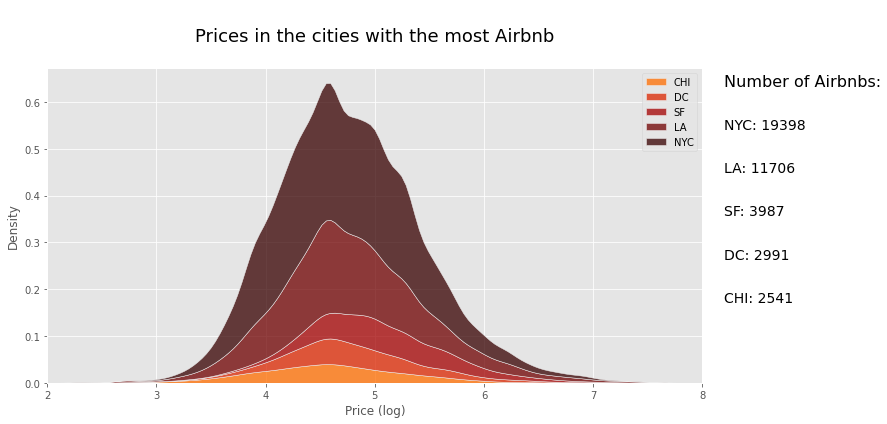

In [21]:
#Creating a chart with the data:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=[city_nyc, city_la, city_sf, city_dc, city_chicago], fill=True, ax=ax,
            palette=[colors[0], colors[1], colors[2], colors[3], colors[4]], multiple='stack')
ax.set_xlim(2, 8)
plt.title("\nPrices in the cities with the most Airbnb\n", fontsize=18)
plt.ylabel('Density')
plt.xlabel('Price (log)')
ax.legend(['CHI', 'DC', 'SF', 'LA', 'NYC'])
plt.tight_layout()

#Creating the information table next to the chart:
plt.figtext(1.01, 0.8, "Number of Airbnbs:", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "NYC: {:.0f}".format(df.city.value_counts()[0]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "LA: {:.0f}".format(df.city.value_counts()[1]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "SF: {:.0f}".format(df.city.value_counts()[2]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.4, "DC: {:.0f}".format(df.city.value_counts()[3]), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.3, "CHI: {:.0f}".format(df.city.value_counts()[4]), fontsize=14, va='center', ha='left')
plt.show()

In this comparative analysis of the top five cities with the highest presence of Airbnbs, we observed a notable difference in the density of lodging locations on the platform. When studying the distributions, it can be stated that the fourth and fifth cities exhibit greater symmetry, while the first three have a slight skew to the left, but still quite symmetric.

Furthermore, the significant number of Airbnbs in a particular city does not necessarily imply a substantial variation in rental prices. This finding challenges expectations and highlights the complexity of the factors influencing rental prices, going beyond simple supply and demand.

...


#### Let's analyze if reviews have an influence on the price:

In [22]:
#reating 5 lists for the reviews:
review1, review2, review3, review4, review5 = [],[],[],[],[]
rcount1, rcount2, rcount3, rcount4, rcount5 = 0,0,0,0,0

#Let's use a loop to iterate through our dataframe:
for r, price in zip(df['review_scores_rating'],df['log_price']):
    if r <= 20:
        review1.append(price)
        rcount1 += 1
    elif r > 20 and r <= 40:
        review2.append(price)
        rcount2 += 1
    elif r > 40 and r <= 60:
        review3.append(price)
        rcount3 += 1
    elif r > 60 and r <= 80:
        review4.append(price)
        rcount4 += 1
    elif r > 80 and r <= 100:
        review5.append(price)
        rcount5 += 1

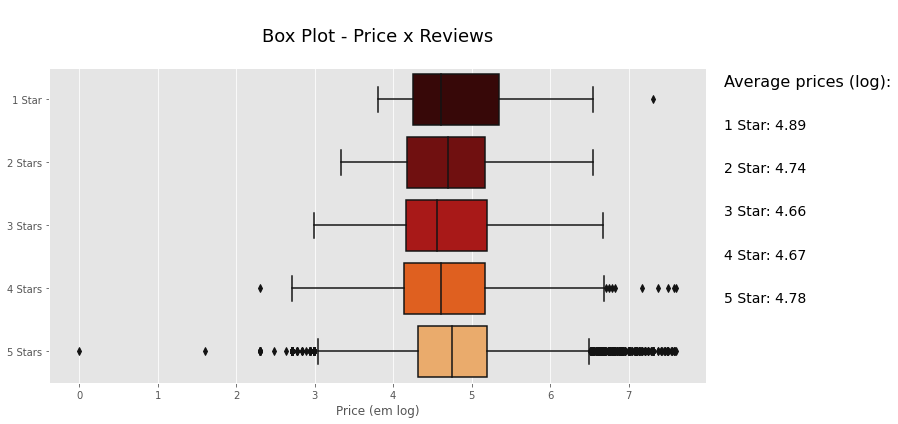

In [23]:
#Creating a list to assign prices in each category:
reviews = [review1, review2, review3, review4, review5]
#Creating a list with the quantity of reviews in each category:
rcounts = [rcount1, rcount2, rcount3, rcount4, rcount5]
#Creating a list with the labels:
stars = ["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]

#Creating a chart with the data:
plt.figure(figsize=(10, 6))
sns.boxplot(data=reviews, orient="h", palette='gist_heat')
plt.yticks(ticks=range(5), labels=stars)
plt.title('\nBox Plot - Price x Reviews\n', fontsize=18)
plt.xlabel("Price (em log)")
plt.tight_layout()

#Creating the information table next to the chart:
plt.figtext(1.01, 0.8, "Average prices (log):", fontsize=16, va='center', ha='left')
plt.figtext(1.01, 0.7, "1 Star: {:.2f}".format(np.mean(review1)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.6, "2 Star: {:.2f}".format(np.mean(review2)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.5, "3 Star: {:.2f}".format(np.mean(review3)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.4, "4 Star: {:.2f}".format(np.mean(review4)), fontsize=14, va='center', ha='left')
plt.figtext(1.01, 0.3, "5 Star: {:.2f}".format(np.mean(review5)), fontsize=14, va='center', ha='left')
plt.show()

In this analysis through boxplots, prices related to corresponding ratings from 1 to 5 stars were explored. Remarkably, there is a relative uniformity in the values presented by the boxplots, indicating limited variation in prices associated with different ratings. This consistency suggests that the rating scores are not a significant determining factor in rental prices.

Furthermore, when examining the average rental prices and ratings, there is no clear relationship between these two aspects.

...<br>


#### Let's discover some correlations:

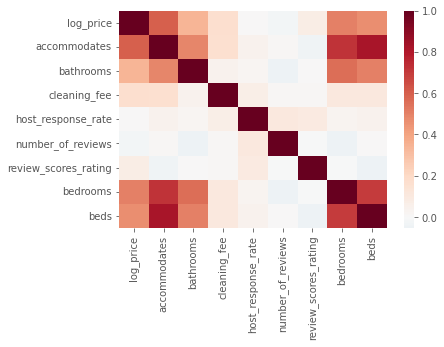

In [24]:
#Performing the correlation:
corr = df.corr()
#Let's use seaborn to analyze the correlations:
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap = 'RdBu_r', center=0);

In [25]:
#Creating a dataframe with our quantitative variables to calculate the correlation between them:
corr_log = df[['log_price', 'accommodates', 'bathrooms', 'cleaning_fee', 'beds','host_response_rate','bedrooms']]
#Performing the correlation:
corr_log.corr().head(1)

,log_price,accommodates,bathrooms,cleaning_fee,beds,host_response_rate,bedrooms
log_price,1.0,0.594578,0.345265,0.170305,0.462411,0.002971,0.502518


<br>

The table above reveals moderate correlations between price and variables such as the quantity of beds, the quantity of bathrooms, and the accommodation capacity. These are the most important variables as they have a direct influence on prices. In contrast, other correlations appear to be less relevant, such as those with reviews, as evidenced in the previous boxplot.

...


### 2.3 Using Sweetviz for analysis:

Normally used to perform a more comprehensive exploratory analysis quickly and intuitively, creating an analysis of the DataFrame data through Pandas. Then it is opened as a new tab in the browser.

The tool requires an installation:

**PIP INSTALL**<br>
To install via PIP, uncomment the command:


In [26]:
#pip install sweetviz

#### To access the tool's analysis, uncomment the following lines:

In [27]:
#import sweetviz as sv

#my_report = sv.analyze(df)
#my_report.show_notebook()

___
## 3. Prediction Models:

Adapting our dataframe for predictions:

In [28]:
#Removing columns:
df_pred = df_models.drop(["log_price"],axis=1)

In [29]:
#Importing libraries to use in statsmodel:
from sklearn.linear_model import LinearRegression
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    import statsmodels.api as sm

#Establishing the random_seed variable:
RANDOM_SEED = 10
np.random.seed(RANDOM_SEED)

In [30]:
#Splitting the dataframe data into test and train:
X_train, X_test, y_train, y_test = train_test_split(df_pred, df_models.log_price, test_size = 0.33,random_state = RANDOM_SEED)

<br>
<br>`

- **`AVERAGE PREDICTION MODEL`**` (No use of explanatory variable)`

In [31]:
#Separating the database into training and testing sets once specifically because we need them all to have the price.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(df, df, test_size = 0.33,random_state = RANDOM_SEED)
#Creating a function to calculate the r_squared:
def r_2(y_test, y_train):
    a = 0
    b = 0
    #Let's use a loop to assign values to the variables:
    for i in y_train["log_price"]:
        a += (i - np.mean(y_train["log_price"]))**2
        b += (i - np.mean(y_test["log_price"]))**2
    #Returning the r squared value:
    return 1-(a/b)

In [32]:
#Let's use the function to calculate the r squared::
R2_MEAN = r_2(y_test_2,y_train_2)
#From our r squared, let's calculate the rms:
RMS_Mean = np.sqrt(R2_MEAN)
#Discovering the quality of the prediction model:
print("R2: {:.7f}".format(R2_MEAN))

print("RMS: {:.4f}".format(RMS_Mean))

R2: 0.0000019
RMS: 0.0014


<br>
<br>

- **`K-Nearest Neighbors Regression`**

In [33]:
#Importing the necessary libraries for this model:
from sklearn.neighbors import KNeighborsRegressor

In [34]:
#Calling the classifier:
knn = KNeighborsRegressor(n_neighbors=3)

#Fitting the training data (training the algorithm):
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

In [35]:
#Discovering the quality of the prediction model:
knn_test = r2_score(y_test, knn_pred)
print('R2: {:.2f}'.format(knn_test))


RMS_K_Nearest = np.sqrt(np.mean(knn_test))
print("RMS: {:.2f}".format(RMS_K_Nearest))

R2: 0.44
RMS: 0.66


<br>
<br>

- **`Multiple Linear Regression`**

In [36]:
#Importing the necessary libraries for this model:
from sklearn.linear_model import LinearRegression

In [37]:
#Calling the classifier with statsmodel:
linear = LinearRegression()
Xc = sm.add_constant(X_test)
model = sm.OLS(y_test,Xc)
#Fitting the training data (training the algorithm):
results = model.fit()

linear_test=results.rsquared

In [38]:
#Discovering the quality of the prediction model:
print("R2: {:.2f}".format(results.rsquared))

RMS_Linear_Regression = np.sqrt(np.mean(results.rsquared))
print("RMS: {:.2f}".format(RMS_Linear_Regression))

R2: 0.75
RMS: 0.86


<br>
<br>

- **`Decision Tree Regression`**

In [39]:
#Importing the necessary libraries for this model:
from sklearn.tree import DecisionTreeRegressor

In [40]:
#Calling the classifier:
tree = DecisionTreeRegressor()

#Fitting the training data (training the algorithm):
tree.fit(X_train, y_train)   

tree_pred = tree.predict(X_test)

In [41]:
#Discovering the quality of the prediction model:
tree_test = r2_score(y_test, tree_pred)
print("R2: {:.2f}".format(tree_test))


RMS_Tree_Regression = np.sqrt(np.mean(tree_test))
print("RMS: {:.2f}".format(RMS_Tree_Regression))

R2: 0.50
RMS: 0.71


<br>
<br>

- **`MODELO RANDOM FOREST`**

In [42]:
#Importing the necessary libraries for this model:
from sklearn.ensemble import RandomForestRegressor

In [43]:
#Calling the RandomForestClassifier:
model = RandomForestRegressor()

#Fitting the training data (training the algorithm):
model.fit(X_train, y_train)

random_pred = model.predict(X_test)

In [44]:
#Discovering the quality of the prediction model:
random_test = r2_score(y_test, random_pred)
print('R2: {:.2f}'.format(random_test))


RMS_RANDOM_FOREST = np.sqrt(np.mean(random_test))
print("RMS: {:.2f}".format(RMS_RANDOM_FOREST))

R2: 0.71
RMS: 0.84


### 3.1 Model Comparison

This section is dedicated to comparing regression models with the goal of facilitating the evaluation and analysis of the performance of different regression algorithms to determine which one offers the best solution for the problem at hand.

In [45]:
#Assigning values to lists to plot a table later:
Values_r2 = [R2_MEAN, knn_test,linear_test,tree_test,random_test]
Values_rms = [RMS_Mean, RMS_K_Nearest,RMS_Linear_Regression,RMS_Tree_Regression,RMS_RANDOM_FOREST]

In [46]:
#Creating a dictionary with the lists:
TABLE = {"Regressions":["AVERAGE","KNN","LINEAR","TREE","FOREST"],'$R^2$':Values_r2,"$RMS$":Values_rms}

In [47]:
#Transforming the dictionary into a table:
table = pd.DataFrame.from_dict(TABLE)
table.set_index("Regressions", inplace=True)
#Viewing the results:
table

,$R^2$,$RMS$
Regressions,,
AVERAGE,0.000002,0.001363
KNN,0.436151,0.660418
LINEAR,0.746610,0.864066
TREE,0.502708,0.709019
FOREST,0.712353,0.844010


___
## 4. Conclusion

Due to the exploratory analysis, it was observed that the price shows significant positive correlations with features such as accommodates, bathrooms, beds, and bedrooms. These results indicate that as these specific characteristics increase, there is a corresponding tendency for an increase in recorded rental prices.

Furthermore, after completing each prediction, crucial indicators were calculated in choosing the best predictive model. Highlighting linear regression as the preferred option, with $R^2$ and $RMS$ values of 0.75 and 0.86, respectively. This model, according to the dataframe analysis, takes into consideration more comprehensively the variables that impact the problem.

The other models exhibit lower $R^2$ and $RMS$ values compared to linear regression. The average-based model is identified as the least effective, with indicators close to zero, as it does not consider any variable other than the price itself. Regression tree and random forest prediction models are similar and reliable, presenting $R^2$ and $RMS$ values close to linear regression, although slightly affected by the lack of an exact rule in the dataframe's data. The k-neighbors model is acceptable but less precise due to the increased number of variables, resulting in excessive calculations of vectors used by the model and making it challenging to identify relevant patterns in the data.

___
## 5. Bibliographic References

- https://www.mldata.io/tutorials/scikit_knn/
- https://www.kaggle.com/pratsiuk/valueerror-unknown-label-type-continuous
- https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html